In [24]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import KFold
#Loading the dataset
dataset = open("breast-cancer.data")
df = []
list_for_pop = []
for data in dataset:
    df.append([data])
    
#Removing the instances with missing data
for i in range(len(df)):
    df[i]= df[i][0].split()
    df[i]= df[i][0].split(",")
    for j in range(len(df[i])):
        if(df[i][j].isalnum()):
            df[i][j] = np.int(df[i][j])
        else:
            list_for_pop.append(df[i][0]) 
for pp in list_for_pop:
    for i in range(len(df)):
        if(df[i][0] == pp):
            df.pop(i)
            break
df = pd.DataFrame(df)
#naming the columns
df.columns = ['Sample code number','Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses','target']
df = df.drop_duplicates() #removing duplicates
df = df.sample(frac=1).reset_index(drop=True)

In [27]:
def entropy_function(att):
    vals = list(att)
    total = len(vals)
    distinct_val = {x:0 for x in set(vals)}
    #calculate sum of each distinct value
    for val in vals:
        distinct_val[val]+=1
    for key in distinct_val:
        distinct_val[key] = distinct_val[key]/total
    if 1 in distinct_val.values():
        return 0
    entropy = 0
    #entropy formula
    for val in distinct_val:
        entropy-=(distinct_val[val])*math.log((distinct_val[val]),len(distinct_val.keys()))
    return entropy

def info_gain_att(train, att, target):
    #total entropy for training data
    total_entropy = entropy_function(train[target])
    vals,counts= np.unique(train[att],return_counts=True)
    distinct_vals = dict(zip(vals,counts))
    #calculate entropy for attribute
    entropy = sum([(distinct_vals[i]/sum(distinct_vals.values()))*entropy_function(train.where(train[att]==i).dropna()[target]) for i in distinct_vals])
    #return gain
    return total_entropy - entropy

def Id3 (train_before,train,uniq, target=10):
    #End conditions: if only 4, if only 2 or training data doesn't exist for a particular attribute value 
    if 4.0 not in list(train[target]):
        return 2
    if 2.0 not in list(train[target]):
        return 4
    if len(train)==0:
        return int(train_before[target].mode())
    #calculate information gain for all the attributes in the training data
    info_gain_attr = {att:info_gain_att(train,att,target) for att in train.drop(columns=[uniq,target])}
    #find attribute with max gain and make it root attribute
    best_attr = max(info_gain_attr, key=lambda k: info_gain_attr[k])
    tree = {best_attr:{}}
    for val in set(df[best_attr]):
        split_train = train.where(train[best_attr] == val).dropna()
        sub_tree = Id3(train,split_train,uniq,target)
        tree[best_attr][val] = sub_tree
    return tree

def Id3_Predict(data, DT_model):
    #ID3 prediction
    if type(DT_model) == int:
        return DT_model
    key = ''.join(list(DT_model.keys()))
    return Id3_Predict(data, DT_model[key][data[key]])

def test_accuracy(test,DT_model):
    #test model
    test_dict = test.reset_index().to_dict(orient="records")
    predicted = pd.DataFrame(columns=["predicted"])
    for record in range(len(test_dict)):
        predicted.loc[record,"predicted"] = Id3_Predict(test_dict[record],DT_model)
    print("Accuracy -->",(np.sum(predicted["predicted"] == test.reset_index()["target"])/len(test))*100,'%')
    return (np.sum(predicted["predicted"] == test.reset_index()["target"])/len(test))*100

In [29]:
#k-fold cross valic
kf = KFold(n_splits=6, shuffle=True)
kf.get_n_splits(df)
accuracy_list = []
for train_index,test_index in kf.split(df):
    df = df.sample(frac=1)
    train, test = df.iloc[train_index], df.iloc[test_index]
    DT_model = Id3(train,pd.DataFrame(train),uniq = 'Sample code number',target='target')
    acc = test_accuracy(test,DT_model)
    accuracy_list.append(acc)

Accuracy --> 89.38053097345133 %
Accuracy --> 92.92035398230088 %
Accuracy --> 92.03539823008849 %
Accuracy --> 94.64285714285714 %
Accuracy --> 91.07142857142857 %
Accuracy --> 92.85714285714286 %


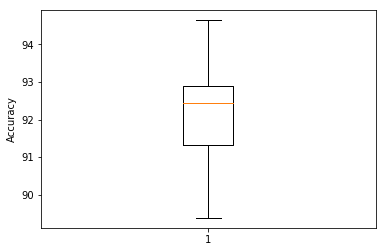

Mean accuracy 92.15128529287823


In [36]:
from matplotlib import pyplot as plt
plt.boxplot(accuracy_list)
plt.ylabel("Accuracy")
plt.show()
print("Mean accuracy",np.mean(accuracy_list))